# Exercise 2 - Recurrent Neural Networks for Sequential Data Analysis - Vehicular Traffic Prediction

In this tutorial we will conduct traffic flow prediction using Recurrent Neural Network.

**Dataset:**
The information on traffic has been acquired from the Bluetooth traffic monitoring system (BTMS) that is used to monitor the road traffic of arterial roads in Victoria, Australia. BTMS consists of a network of Bluetooth traffic scanners that are placed in the junctions of arterial roads. These Bluetooth scanners capture the Bluetooth devices that transit the scanning zone, which are either Bluetooth enabled vehicle stereo systems or the mobile devices of the occupants. The dataset was obtained from Victoria road authority (VicRoads) and comprises all vehicle records for October 2017. The raw dataset consists of approximately 190 million vehicle records obtained from 1,408 Bluetooth scanners placed at the junctions of arterial roads, and using that, we have computed unique vehicle count for each 15-minute sampling interval.

Based on Preliminary impact propagation analysis, we have identified junction *Z* (as shown in Fig.1.) face heavy traffic congestion in frequent time periods and is critically impacted by the neighbouring road segments, *X1, X2* and *X3*. Thus, in this experiment we attempt to utilize Recurrent Neural Network Model(s) to predict the traffic flow (vehicle count) at junction *Z*.

![Fig.1.](https://i.ibb.co/0q7YqfY/Presentation1.png)
Fig. 1: Map of the road network.

## Load Libraries

Load required libraries for modeling and data processing

In [ ]:
%tensorflow_version 1.x
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.callbacks import ModelCheckpoint
%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


## Load data from google drive

Libraries to load data from google drive shared location.

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authenticate and create the python document (PyDrive) client.

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

When prompted, click on the link to get authentication to allow Google to access your Drive. You should see a screen with “Google Cloud SDK wants to access your Google Account” at the top. After you allow permission, copy the given verification code and paste it in the box in Colab.

In [ ]:
dataset_file_id = '1W-F_dtThEd20Ytu8tgnr6qsMZoFTo2pA'

Download the dataset file.

In [ ]:
downloaded = drive.CreateFile({'id':dataset_file_id}) 
downloaded.GetContentFile('bluetooth_traffic_counts.csv')  

Load the dataset file to a dataframe using Pandas library.

In [ ]:
df = pd.read_csv('bluetooth_traffic_counts.csv', index_col=0)

Explore the dataset.

In [ ]:
df.head(10)

,day_of_week,hour_of_day,min_of_hour,week_day,v_count_x1,v_count_x2,v_count_x3,v_count_z
time,,,,,,,,
01-10-17 0:00,1,0,0,0,3,3,1,2
01-10-17 0:15,1,0,15,0,1,0,2,2
01-10-17 0:30,1,0,30,0,4,6,2,2
01-10-17 0:45,1,0,45,0,1,1,1,1
01-10-17 1:00,1,1,0,0,1,1,1,0
01-10-17 1:15,1,1,15,0,4,2,2,0
01-10-17 1:30,1,1,30,0,4,4,4,2
01-10-17 1:45,1,1,45,0,0,0,1,1
01-10-17 2:00,1,2,0,0,0,0,0,0


Dataset contains 8 columns:  


1.   Day of the week
2.   Hour of the day
3.   Minute of the hour
4.   Whether the current day is a weekday (1) or weekend (0)
5.   Vehicle count per 15-min interval for X1 road segment
6.   Vehicle count per 15-min interval for X2 road segment
7.   Vehicle count per 15-min interval for X3 road segment
8.   Vehicle count per 15-min interval for Z road segment (Our predictor)



## Preprocessing

We will conduct 2 pre-processing steps for this dataset,  
1. Normalize the dataset  
2. Format the dataset to adapt recurrent learning.

### Standardization

Copy the index (i.e., actual time frame) for evaluation and visualization purposes.

In [ ]:
date_times = df.index.values

Load features from the dataframe, and normalize between 0-1.  
This scaler *object* is the min max scaler, which can be used to inverse the scale after prediction.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

Scale the dataset using the min-max scaler object.

In [ ]:
values = df.values.astype('float32')
scaled_values = scaler.fit_transform(values)

### Format to adapt recurrent learning

Define how many duration is required/used to predict the traffic on junction Z.  
* For this experiment, we take 1 hour previous traffic count (i.e., four 15-min intervals) - used as *n_15min_interval*  
* Define the number of feature columns in order to construct data records combining sequence of *n_15min_interval* s 

In [ ]:
n_15min_interval = 4
n_features = df.shape[1]

The following function will enable to construct input records capturing more than 1 hour of input time steps.  
This is one of the most important pre-processing steps to use Backpropagation through time by recurrent neural networks when learning sequence predictions problems.

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
df_reframed = series_to_supervised(scaled_values, n_15min_interval, 1)

In [ ]:
df_reframed.head()

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
4,0.0,0.000000,0.000000,0.0,0.076923,0.075,0.026316,0.090909,0.0,0.000000,0.333333,0.0,0.025641,0.000,0.052632,0.090909,0.0,0.000000,0.666667,0.0,0.102564,0.150,0.052632,0.090909,0.0,0.000000,1.000000,0.0,0.025641,0.025,0.026316,0.045455,0.0,0.043478,0.000000,0.0,0.025641,0.025,0.026316,0.000000
5,0.0,0.000000,0.333333,0.0,0.025641,0.000,0.052632,0.090909,0.0,0.000000,0.666667,0.0,0.102564,0.150,0.052632,0.090909,0.0,0.000000,1.000000,0.0,0.025641,0.025,0.026316,0.045455,0.0,0.043478,0.000000,0.0,0.025641,0.025,0.026316,0.000000,0.0,0.043478,0.333333,0.0,0.102564,0.050,0.052632,0.000000
6,0.0,0.000000,0.666667,0.0,0.102564,0.150,0.052632,0.090909,0.0,0.000000,1.000000,0.0,0.025641,0.025,0.026316,0.045455,0.0,0.043478,0.000000,0.0,0.025641,0.025,0.026316,0.000000,0.0,0.043478,0.333333,0.0,0.102564,0.050,0.052632,0.000000,0.0,0.043478,0.666667,0.0,0.102564,0.100,0.105263,0.090909
7,0.0,0.000000,1.000000,0.0,0.025641,0.025,0.026316,0.045455,0.0,0.043478,0.000000,0.0,0.025641,0.025,0.026316,0.000000,0.0,0.043478,0.333333,0.0,0.102564,0.050,0.052632,0.000000,0.0,0.043478,0.666667,0.0,0.102564,0.100,0.105263,0.090909,0.0,0.043478,1.000000,0.0,0.000000,0.000,0.026316,0.045455
8,0.0,0.043478,0.000000,0.0,0.025641,0.025,0.026316,0.000000,0.0,0.043478,0.333333,0.0,0.102564,0.050,0.052632,0.000000,0.0,0.043478,0.666667,0.0,0.102564,0.100,0.105263,0.090909,0.0,0.043478,1.000000,0.0,0.000000,0.000,0.026316,0.045455,0.0,0.086957,0.000000,0.0,0.000000,0.000,0.000000,0.000000


Drop the records of the current time frame, except the predictor.

In [ ]:
df_reframed.drop(df_reframed.columns[[32, 33, 34, 35, 36, 37, 38]], axis=1, inplace=True)

### Train-Test split

Split the dataset into train set and test set.  
First *n_obs* parametarized number of feature columns in the dataset. 

In [ ]:
n_obs = n_15min_interval * n_features
n_obs

32

For this experiment we use 70/30 train/test split.

In [ ]:
n_train_records = int(len(df_reframed.values) * .7) 
n_train_records

2081

Split the dataset for training and testing.



In [ ]:
train = df_reframed.values[:n_train_records, :]
test = df_reframed.values[n_train_records:, :]
test_date_times = date_times[n_train_records:]
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (2081, 33)
Test shape: (892, 33)


Construct X set as the features and Y set as the predictor/ or the output variable.

In [ ]:
X_train, y_train = train[:, :n_obs], train[:, -1]  
X_test, y_test = test[:, :n_obs], test[:, -1]
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\nX_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2081, 32)
y_train shape: (2081,)

X_test shape: (892, 32)
y_test shape: (892,)


The inputs (X) are reshaped into the 3D format expected by RNN, namely (samples, timesteps, features).

In [ ]:
X_train = X_train.reshape((X_train.shape[0], n_15min_interval, n_features))
X_test = X_test.reshape((X_test.shape[0], n_15min_interval, n_features))
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (2081, 4, 8)
X_test shape: (892, 4, 8)


## Modelling

We design a RNN based on hierarchically stacked three layered LSTM network architecture that consists of 256, 128 and 64 LSTM Networks respectively, accommodating deeper abstraction of temporal hierarchy to be trained by the prediction model. The proposed RNN architecture captures the correlation patterns of the targeted road segment, and the surrounding road segments that impact the traffic flow of the targeted road segment, which was identified through the impact propagation analysis.

Model design:

In [ ]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(24, return_sequences=True))
model.add(LSTM(12))
model.add(Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Compile the model with [Mean Squarred Error](https://keras.io/losses/) loss functions and [ADAM optimizer](https://keras.io/optimizers/).

In [ ]:
model.compile(loss='mse', optimizer='adam')

Train the model with parameters;  
*   Train epochs: 50
*   Batch size: 32
*   Use 0.3 from the training dataset as model validation data.



In [ ]:
train_epochs = 50
batch_size = 32
validation_split = 0.3
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=batch_size, validation_split=validation_split, verbose=1, shuffle=False)


Train on 1456 samples, validate on 625 samples
Epoch 1/50
1456/1456 [==============================] - 1s 902us/step - loss: 0.0328 - val_loss: 0.0224
Epoch 2/50
1456/1456 [==============================] - 0s 208us/step - loss: 0.0162 - val_loss: 0.0157
Epoch 3/50
1456/1456 [==============================] - 0s 223us/step - loss: 0.0130 - val_loss: 0.0154
Epoch 4/50
1456/1456 [==============================] - 0s 221us/step - loss: 0.0130 - val_loss: 0.0164
Epoch 5/50
1456/1456 [==============================] - 0s 228us/step - loss: 0.0127 - val_loss: 0.0154
Epoch 6/50
1456/1456 [==============================] - 0s 215us/step - loss: 0.0123 - val_loss: 0.0149
Epoch 7/50
1456/1456 [==============================] - 0s 234us/step - loss: 0.0124 - val_loss: 0.0152
Epoch 8/50
1456/1456 [==============================] - 0s 225us/step - loss: 0.0123 - val_loss: 0.0154
Epoch 9/50
1456/1456 [==============================] - 0s 220us/step - loss: 0.0121 - val_loss: 0.0148
Epoch 10/50
1456

Visualize the learning curve.

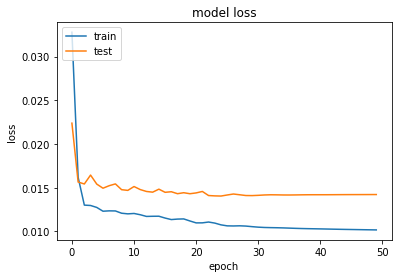

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Evaluation

Make predictions using the trained RNN model for the X_test (test dataset.)

In [ ]:
yhat = model.predict(X_test, batch_size=batch_size)
yhat.shape

(892, 1)

Reshape the test dataset for calculations. (From 3D to 2D)

In [ ]:
X_test = X_test.reshape((X_test.shape[0], n_15min_interval * n_features))
X_test.shape

(892, 32)

Evaluate the accuracy using root mean square error (RMSE)

In [ ]:
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)
rmse

0.113940805

Rescale the predictions using the min-max scaler object.

In [ ]:
inv_yhat = np.concatenate((yhat, X_test[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

Rescale the test data (y_test) using the min-max scaler object.

In [ ]:
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

Reformat the index of the initial dataset (i.e., date and time of each record) in a more readable format for plotting.

In [ ]:
test_date_times_desc = []
for dt in test_date_times:
    cur = dt.split(' ')
    cur_t = cur[1].split(':')
    try:
        if cur[1] == '0:00':
            test_date_times_desc.append(cur[0])
        elif cur_t[1] == '00':
            test_date_times_desc.append(cur_t[0]+':'+cur_t[1])
        else:
            test_date_times_desc.append('')
    except:
        test_date_times_desc.append('')

Setup plot axes for prediction plot.

In [ ]:
x_ticks_range = range(len(inv_y))
x_axis_labels = test_date_times_desc

Plot the prediction with respect to actual traffic count.

Text(0, 0.5, 'Vehicle count (per 15min)')

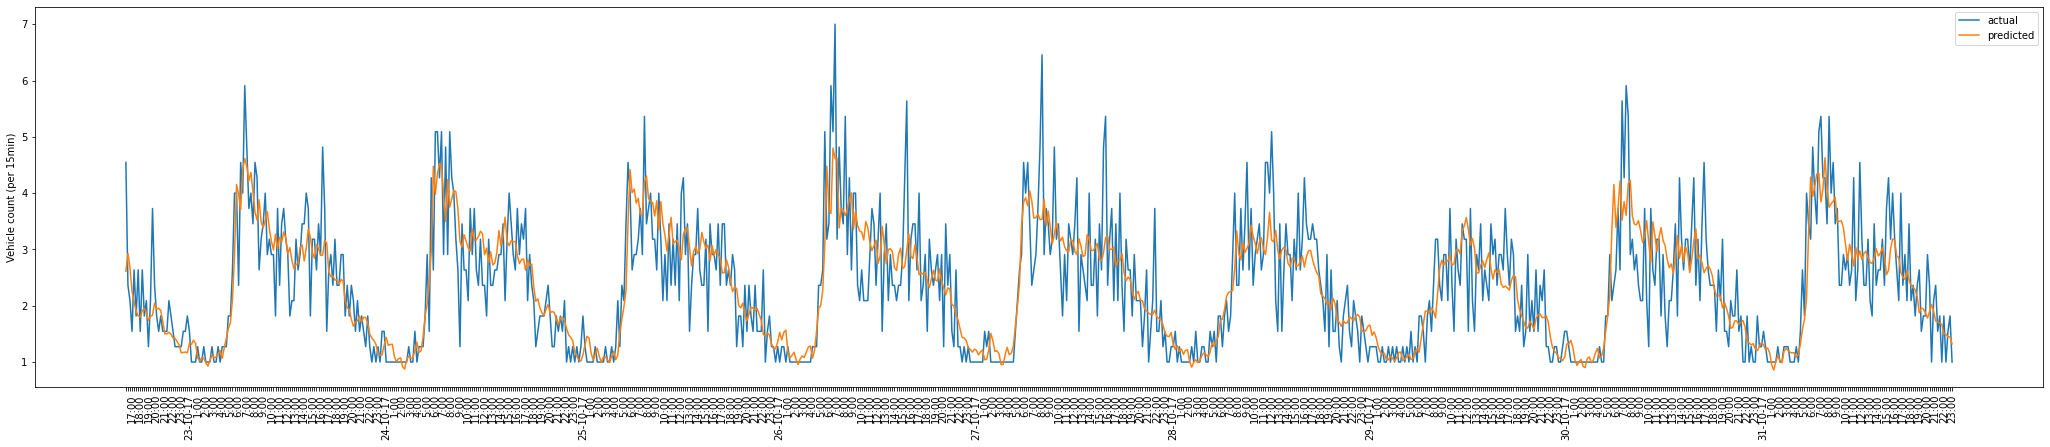

In [ ]:
plt.figure(figsize=(36,7))
plt.plot(x_ticks_range, inv_y, label='actual')
plt.plot(x_ticks_range, inv_yhat, label='predicted')
plt.xticks(x_ticks_range, x_axis_labels, rotation=90)
plt.legend()
plt.ylabel('Vehicle count (per 15min)')